### Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  

In [33]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Multi-class Classification

#### Importing Required Libraries:

In [34]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#os.environ['OMP_NUM_THREADS'] = '1'
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.2'

#### Load Image Data:

In [35]:
DATA_LIST = os.listdir('drive/MyDrive/Covid_Data_GradientCrescent/all/train')
DATASET_PATH  = 'drive/MyDrive/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  'drive/MyDrive/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches:

In [36]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


# **Architecture 1: VGG16**

#### Build Model

In [37]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import datasets, layers, models
from keras.models import Model, Sequential

vgg16_model = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)
model = Sequential()
for layer in vgg16_model.layers[:-4]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

#### Train Model

In [38]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history = model.fit(x=train_batches, epochs=NUM_EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN, 
           validation_data=valid_batches, validation_steps=STEP_SIZE_VALID)

22
6


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 9s 395ms/step - loss: 2.9119 - accuracy: 0.3204 - val_loss: 1.4073 - val_accuracy: 0.4000
Epoch 2/100
21/21 [==============================] - 9s 422ms/step - loss: 1.4734 - accuracy: 0.4951 - val_loss: 1.2133 - val_accuracy: 0.4600
Epoch 3/100
21/21 [==============================] - 8s 374ms/step - loss: 1.3317 - accuracy: 0.4272 - val_loss: 1.2757 - val_accuracy: 0.5000
Epoch 4/100
21/21 [==============================] - 8s 363ms/step - loss: 1.1383 - accuracy: 0.5049 - val_loss: 0.8776 - val_accuracy: 0.6200
Epoch 5/100
21/21 [==============================] - 8s 363ms/step - loss: 1.1197 - accuracy: 0.5340 - val_loss: 1.1050 - val_accuracy: 0.4400
Epoch 6/100
21/21 [==============================] - 8s 386ms/step - loss: 0.8678 - accuracy: 0.6796 - val_loss: 0.8470 - val_accuracy: 0.5800
Epoch 7/100
21/21 [==============================] - 9s 422ms/step - loss: 1.0159 - accuracy: 0.5583 - val_loss: 0.8856 - val_accuracy: 0.5800

#### Plot Accuracy and Loss During Training

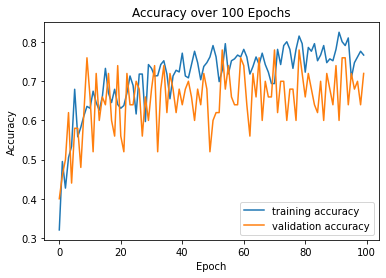

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy over 100 Epochs")
plt.legend(loc='lower right')

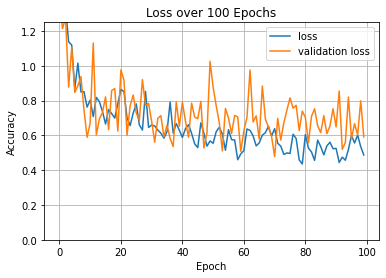

In [40]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Loss over 100 Epochs")
plt.ylim((0,1.25))
plt.grid()
plt.legend(loc='upper right')

In [41]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 26ms/step - loss: 0.9803 - accuracy: 0.6111
Test loss: 0.9803378582000732
Test accuracy: 0.6111111044883728


## TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [45]:
from sklearn.manifold import TSNE


intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_6').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")

outputs = []
labels = []
for i in range(len(tsne_eval_generator)):
  img, label = tsne_eval_generator[i]
  labels.append(label)
  cur = intermediate_layer_model(img)
  outputs.append(np.squeeze(cur))

features = np.array(outputs)
labels = np.array(labels).astype('int32')

# print(len(labels))

# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(features)

# LABEL_COLOR_MAP = {0: 'r', 1: 'b', 2: 'g', 3: 'o'}
# label_color = [LABEL_COLOR_MAP[l[0]] for l in labels]

# X = X_tsne[:,0]
# Y = X_tsne[:,1]

# plt.scatter(Y, X)
# plt.show()

Found 270 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


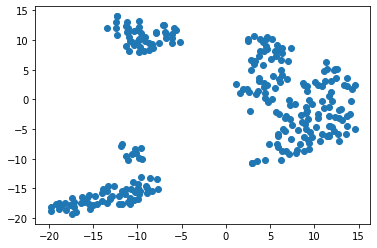

In [46]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(features)

X = X_tsne[:,0]
Y = X_tsne[:,1]

plt.scatter(X, Y)
plt.show()